In [1]:
from PyNite import FEModel3D
from PyNite import Visualization
from PyNite import Reporting
import numpy as np
from GPyOpt.methods import BayesianOptimization

In [2]:
def Ixx(section, vars):
    """
    return Ixx of sections
    section: "solid circular", "thin circular", "rectangular"
    vars:   vars[0] = r for solid circular
            vars[0] = r and vars[1] = t for thin-walled cirular
             
    """
    if section == "solid circular":
        return(np.pi*vars[0]**4/4)
    elif section == "thin circular":
        return(np.pi*(vars[0]**4 - vars[1]**4)/64)
    elif section == "rectangular":
        return(vars[0]*vars[1]**3/12)
    else:
        print("invalid section")

In [3]:
def J(section, vars):
    """
    return J of sections
    section: "solid circular", "thin circular", "rectangular"
    vars:   vars[0] = r for solid circular
            vars[0] = r and vars[1] = t for thin-walled cirular
            vars[0] = b and vars[1] = h for rectangular
    """
    if section == "solid circular":
        return(np.pi*vars[0]**4/2)
    elif section == "thin circular":
        return(np.pi*(vars[0]**4 - vars[1]**4)/32)
    elif section == "rectangular":
        return(vars[0]*vars[1]*(vars[0]**2+vars[1]**2)/12)
    else:
        print("invalid section")

In [4]:
def area(section, vars):
    """
    return area of sections
    section: "solid circular", "thin circular", "rectangular"
    vars:   vars[0] = r for solid circular
            vars[0] = r and vars[1] = t for thin cirular
            vars[0] = b and vars[1] = h for rectangular 
    """
    if section == "solid circular":
        return(np.pi*vars[0]**2)
    elif section == "thin circular":
        return(np.pi*(vars[1]**2-vars[0]**2))
    elif section == "rectangular":
        return(vars[0]*vars[1])
    else:
        print("invalid section")

In [5]:
def truss(vars, visual = False):
    """
    truss setup taken from PyNite examples
    solid circular cross section
    material properties taken for steel
    """
    r = vars[0]
    
    # Create a new model
    truss = FEModel3D()
    
    #Define the nodes
    truss.AddNode('A', 1.1, -0.4, 0)
    truss.AddNode('B', 1, 0, 0)
    truss.AddNode('C', 0, 0, 0.6)
    truss.AddNode('D', 0, 0, -0.4)
    truss.AddNode('E', 0, 0.8, 0)

    # Define the supports
    truss.DefineSupport('C', True, True, True, True, True, True)
    truss.DefineSupport('D', True, True, True, True, True, True)
    truss.DefineSupport('E', True, True, True, True, True, True)
    

    # Create members
    # using steel
    E = 200*10**9 #Pa
    G = 79.3*10**9 #Pa
    rho = 7850 #kg/m**3
    section = "solid circular"
    detail = {}
    member_names = ['AB','AC','AD','BC','BD','BE']
    weight = 0
    for i, member in enumerate(member_names):
        if len(r) == 1:
            sec_area = area(section, r)
            truss.AddMember(member, member[0], member[1], E, G, Ixx(section, r), Ixx(section, r), J(section, r), sec_area)
        else:
            sec_area = area(section, [r[i]])
            truss.AddMember(member, member[0], member[1], E, G, Ixx(section, [r[i]]), Ixx(section, [r[i]]), J(section, [r[i]]), sec_area)
        weight += truss.GetMember(member).L()*sec_area*rho
        print(weight)
        
    # Release the moments at the ends of the members to make truss members
    truss.DefineReleases('AC', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('AD', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('BC', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('BD', False, False, False, False, True, True, \
                               False, False, False, False, True, True)
    truss.DefineReleases('BE', False, False, False, False, True, True, \
                               False, False, False, False, True, True)

    # Add nodal loads
    truss.AddNodeLoad('A', 'FX', 10)
    truss.AddNodeLoad('A', 'FY', 60)
    truss.AddNodeLoad('A', 'FZ', 20)

    # Analyze the model
    truss.Analyze()
    
    if visual:
        Visualization.RenderModel(truss, deformed_shape=True, text_height=0.05, output_file=True)
        #Reporting.CreateReport(truss, 'PyNite Report.pdf')

    x_deflect = [truss.GetNode(node_name).DX['Combo 1'] for node_name in ['A','B','C','D','E']]
    y_deflect = [truss.GetNode(node_name).DY['Combo 1'] for node_name in ['A','B','C','D','E']]
    z_deflect = [truss.GetNode(node_name).DZ['Combo 1'] for node_name in ['A','B','C','D','E']]

    max_deflect = max(max(x_deflect), max(y_deflect), max(z_deflect))
    print(f"maximum deflection: {max_deflect} m")
    print(f"weight: {weight} kg")
    return(1000 * max_deflect + weight)

In [6]:
r_domain = [{'name': 'r', 'type': 'continuous', 'domain': (0.0001,0.1)}]

Opt_r = BayesianOptimization(truss,
                            domain=r_domain,
                            acquisition_type="EI",
                            model_type='GP',
                            exact_feval=False)
Opt_r.run_optimization(max_iter = 50, max_time = 600, eps=1e-6)

40.48486633773628
169.63394153482966
291.0885405480385
405.5970346394157
511.35114196518265
637.095982109827
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.3900591240832967e-07 m
weight: 637.095982109827 kg
12.370526357371675
51.83322398437717
88.94480305649219
123.9339353530699
156.24808358712983
194.67058562372145
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination C

4.533499975911061
18.99562822923351
32.59612815696669
45.418802458869735
57.26115952667543
71.34208114837593
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.2429341552498162e-06 m
weight: 71.34208114837593 kg
0.13888676955977233
0.5819436317492148
0.9986039404285318
1.3914350467197654
1.754233486305141
2.1856118312602044
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.06839218838731592
0.28656724193057354
0.4917438070925213
0.685186127847957
0.8638394243814956
1.0762636108456942
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 8.240331737063028e-05 m
weight: 1.0762636108456942 kg
1.5953327708243257
6.684536975298396
11.470535287771373
15.982817769767392
20.15012788655565
25.1051859710091
+-----------+
| Analyzing |
+-----------+

...Analyzing load combina

2.009372629832519
8.41938803421416
14.447505923711716
20.130869973652597
25.3797303003741
31.620784377754113
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.8045327087544608e-06 m
weight: 31.620784377754113 kg
62.45878686731381
261.7059449177554
449.08230551969683
625.7424324739483
788.8965650503051
982.8917756245372
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination C

28.563928409384168
119.68451918256886
205.37630441072136
286.16729431313183
360.7816631849853
449.50041013051157
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.9710227954040836e-07 m
weight: 449.50041013051157 kg
10.670728836051
44.7109736366221
76.7231601447751
106.90453902547307
134.778495509801
167.9214749264179
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Co

0.2220262724723048
0.9303029781441304
1.5963817955610446
2.224366927028
2.8043414303966827
3.4939487001116385
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.538308691922502e-05 m
weight: 3.4939487001116385 kg


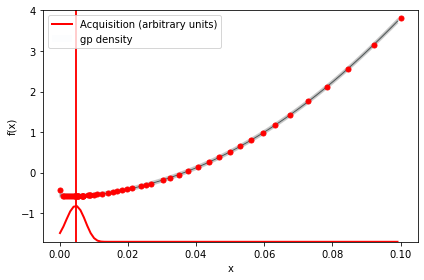

In [7]:
Opt_r.plot_acquisition()

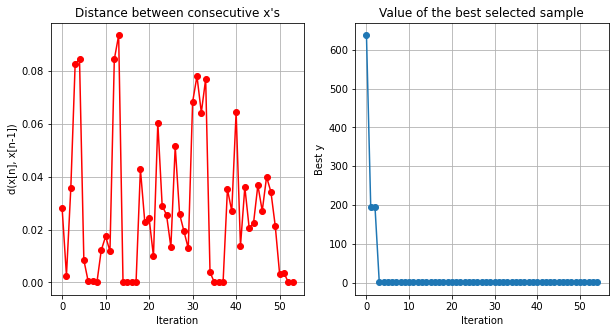

In [8]:
Opt_r.plot_convergence()

In [9]:
print(Opt_r.x_opt)

[0.00135768]


In [10]:
truss([Opt_r.x_opt], True)

0.01874308189593154
0.07853460184338985
0.13476384753118448
0.18777728876697647
0.2367377540900495
0.29495323187279454
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.00030068444803862867 m
weight: 0.29495323187279454 kg


0.5956376799114231

In [15]:
rs_domain = [{'name': 'r', 'type': 'continuous', 'domain': (0.0001,0.1)}]*6

Opt_rs = BayesianOptimization(truss,
                            domain=rs_domain,
                            acquisition_type="EI",
                            model_type='GP',
                            exact_feval=False)
Opt_rs.run_optimization(max_iter = 500, max_time = 600, eps=1e-6)

60.22918622230738
88.68525073923396
144.25851359291133
308.1192029831717
328.5952393366416
636.2046029884013
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.318724424654372e-07 m
weight: 636.2046029884013 kg
2.944591910976227
11.03898453781894
220.01934693616843
243.95507518171695
314.33724575167344
453.22581979431925
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination 

0.2495380444937571
0.2498624159129923
0.25016746184997973
0.25045506191746936
0.2507206744263538
84.31549451550967
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.014163562034921693 m
weight: 84.31549451550967 kg
1.3919963193607847
50.87048006624709
50.87078511218408
50.87107271225157
50.87133832476045
50.87165414608706
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinatio

6.531177976764018
9.122689151928473
9.12299419786546
9.433813125649875
9.43407873815876
21.164397291901707
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.009546965557301638 m
weight: 21.164397291901707 kg
2.0075776008621458
2.240137023481406
2.2404420694183935
5.695372217616471
9.091478628043438
22.352180824399454
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Com

0.00010168197899580927
324.37152091718275
324.37182596311976
611.971893452739
611.9721590652479
611.9724748865744
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.0526776320325432 m
weight: 611.9724748865744 kg
91.86765640698026
393.7062642296726
673.4097011928126
888.2208610384761
1110.1847250580813
1110.3620248131058
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination 

15.220935105163138
39.50021484836424
74.75283777145094
75.55694870587298
75.66525431722705
81.40564960507562
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.8479172405307126e-05 m
weight: 81.40564960507562 kg
84.73719582113876
85.86000126314555
85.87484329506202
88.49229392542371
308.82967448161594
314.8709556631077
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Co

1.4483697372969377
25.694396625076855
25.952156237311872
35.97837485014615
75.90832499403763
91.04454888917634
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.202337543779921e-05 m
weight: 91.04454888917634 kg
0.8461774983763354
1.760229804583016
3.167994450770042
6.905153727268631
11.187634390696942
15.999781676140145
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination

0.00010168197899580927
0.000426053398231013
0.0007310993352184408
0.0010186994027080601
265.6135275838884
581.4348541940544
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.01416355525683681 m
weight: 581.4348541940544 kg
101.68197899580927
101.68230336722851
101.6826084131655
101.68289601323299
101.68316162574187
117.6027646719222
+-----------+
| Analyzing |
+-----------+

...Analyzing load

0.0005704575554740902
72.02926761639957
246.53669419600084
246.55545353959025
247.0919994521947
269.88435336927773
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.0010079042617550554 m
weight: 269.88435336927773 kg
0.3547682166798096
290.747051845571
573.0610144244098
573.7923042252894
833.8973153620225
946.0741607560931
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

16.175320790141683
20.567877356741906
33.107191459155324
47.34531858842105
56.90222516177842
62.220268978170765
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.648987534745551e-06 m
weight: 62.220268978170765 kg
0.11537155435430235
0.29196293713567933
30.936104003300784
45.05147093115003
45.85950916871296
62.878849929507126
+-----------+
| Analyzing |
+-----------+

...Analyzing load combin

3.473650766423988
7.869377639193132
20.071278286300725
24.689644914354375
46.32950797778327
50.444761648212825
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 3.517344124209907e-06 m
weight: 50.444761648212825 kg
4.97898069313817
8.20235188252868
14.863041522068347
15.49106952906077
46.02018358577472
50.45868886426678
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Co

39.722588374902436
39.81854575980951
141.56753424491012
165.85348592014967
166.28355033126257
169.40335137818406
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.2200562385995261e-05 m
weight: 169.40335137818406 kg
0.04473325919236224
0.23362810362242942
1.5392718912440344
4.320441833160932
8.039806309663756
12.265841523628527
+-----------+
| Analyzing |
+-----------+

...Analyzing load comb

1.1405474074316355
1.5658737317498828
11.830924208048263
11.839760267287138
28.70909468420148
41.966453459179256
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 7.38399801386556e-05 m
weight: 41.966453459179256 kg
8.8085942131899
9.0998473068015
9.324025879559843
24.81769613944958
25.16988448681725
41.19696057675432
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Comb

41.528675209237726
41.668627164034355
61.10872443832979
61.69840137629749
64.3423834812017
66.60725621204283
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 8.51864891031866e-06 m
weight: 66.60725621204283 kg
0.4688395778624578
0.801498407059741
2.1621807659665855
4.489433643417397
7.223189427049197
11.68856972408835
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Com

0.33870576166541555
0.566128999388538
2.066179936129722
3.9474256265683945
6.24337583095936
10.358423072114118
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 7.296907254648332e-06 m
weight: 10.358423072114118 kg
0.15292908792432117
0.8557367744450466
27.98363873202748
29.25816696892062
63.610359894199966
77.69909838072901
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.789330162663905
1.781634577174521
30.81374870877725
54.52275944404127
54.79528786007009
74.21684776264865
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 7.99237220665878e-06 m
weight: 74.21684776264865 kg
0.09832094932183139
0.23906809579661714
1.911036537815013
3.7123112369483238
5.8417526640433195
9.839916050310972
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination 

0.23743103310838437
324.1696591349613
611.776057922054
616.1244215140607
620.8875089554298
921.0034597353854
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.8556660345648256e-06 m
weight: 921.0034597353854 kg
26.427442117754683
37.53931607666854
45.25792679612551
46.371548147644084
49.51426618815157
78.2989187481098
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Co

88.45139028912067
88.4686674259174
149.13113068396825
150.91230916420008
151.35996532007053
402.85364670157253
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.5082626636818602e-05 m
weight: 402.85364670157253 kg
0.046062112175550084
0.12184204732278842
0.3097754518811181
34.304302431671196
38.53153750746302
38.79438316846256
+-----------+
| Analyzing |
+-----------+

...Analyzing load combi

0.0710769769240266
0.07570442276370623
1.5699480343306944
87.21326679031762
191.0163333883871
191.09344457270092
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.0002554499419243988 m
weight: 191.09344457270092 kg
0.06610825174274353
1.1275417817827424
1.7005697750925544
1.8766695402875295
77.78838029294096
78.79503541087442
+-----------+
| Analyzing |
+-----------+

...Analyzing load combin

23.670427753996155
26.345118141822905
30.37769380431737
31.237634252073704
39.390183936695664
45.88211996066134
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 3.2722193954910554e-06 m
weight: 45.88211996066134 kg
0.00010168197899580927
0.11915683581407102
1.4116018244755637
3.113234727850538
5.176191522285168
8.689749784836886
+-----------+
| Analyzing |
+-----------+

...Analyzing load comb

17.932119966381393
18.059271990829004
19.52471833205072
25.496597698921647
32.670976130121815
43.16333418543358
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.1015513561659538e-05 m
weight: 43.16333418543358 kg
0.00010168197899580927
0.1493206526373704
1.4838759910373478
3.241528504098821
5.451934624981328
9.066622141166208
+-----------+
| Analyzing |
+-----------+

...Analyzing load combi

6.674105650418534
6.722605934738404
10.300113343265316
49.311793874691396
49.78284376023427
60.7099536048336
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 2.1662501059902252e-05 m
weight: 60.7099536048336 kg
41.9629445522485
43.42108415780585
71.53121712893044
73.72408035271815
74.6636845097356
81.21404891903711
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 

34.46144121671585
34.699363368400626
34.74483927004256
36.23866952563614
39.91103001272268
51.80776719837535
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 7.464653362138924e-05 m
weight: 51.80776719837535 kg
32.355884435359634
64.05227398959138
69.53907488230699
73.31767601753809
79.65043726192502
82.20993502136845
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Com

0.06403386822738771
0.44230617364434394
2.277477376000188
5.406447183634446
8.21540864358724
11.620552225763094
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.301422253570077e-05 m
weight: 11.620552225763094 kg
1.6624384930316467
45.28027358032246
49.309989458446154
62.53320524699509
66.4605394330284
70.92062685202852
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination

0.944150126861681
12.34305615901827
35.49492865336157
39.3016768700358
39.839905478722734
49.08731481076326
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 4.91521907692664e-06 m
weight: 49.08731481076326 kg
14.112944615849308
38.960237034470566
41.18963558820373
43.51499760203287
43.5157839337701
54.17154110744843
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo

0.11763388038155195
0.7502942459587416
2.276347245625484
5.344289392618775
7.96260428305128
11.336580861500359
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 9.385915748452314e-06 m
weight: 11.336580861500359 kg
0.12320964391191772
0.76403649836387
2.278081551436704
5.381424950514813
7.9877088412407895
11.32933023854834
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination

0.11861504748254707
0.7760059177862715
2.202526517878689
5.11058395734543
8.033197662677534
11.118433746518827
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 9.686644209403853e-06 m
weight: 11.118433746518827 kg
0.01589068686651089
10.340968369894773
10.429329050551083
22.336872365591926
71.00612361264905
71.0258904384974
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.16656116360285098
3.3551667345629257
33.86706131268694
43.41789631589003
43.716516832404444
45.57854370306683
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.507294668388734e-05 m
weight: 45.57854370306683 kg
0.810824821213004
1.0645012083905765
9.29684450685464
46.540855248867445
46.68449062120334
52.542801328143696
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination

9.574514687796803
10.802511622412633
28.176330049387126
285.6133892297461
285.8712545680232
360.39232489217073
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 5.076291720630755e-06 m
weight: 360.39232489217073 kg
13.315629671460306
14.45162306445861
23.442602198566952
35.114492296234175
35.60348643322147
38.105719698964506
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

0.001207182457865249
279.9578838404067
295.9075568411073
297.34320279533364
428.38569122552576
739.009994197814
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.00045290941266685786 m
weight: 739.009994197814 kg
0.6382474385886772
0.6534273888665354
46.17811904896042
51.121079535987676
60.10316790713572
61.968644610512314
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinati

4.316412369164892
30.252279751057984
31.821961088560354
32.627264173041866
38.783484913068314
43.542697053536116
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 4.44396392868594e-06 m
weight: 43.542697053536116 kg
0.0391716769054497
248.6693031173302
251.39265899442626
435.04080749520006
626.1851804600266
628.131855970884
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinatio

23.2425174284857
36.43165258797913
36.88794944300823
51.03535170738381
51.03924875432088
72.02824462076113
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.00022083108022874525 m
weight: 72.02824462076113 kg
0.7634243088970156
2.6025677138231664
11.982612051596822
41.652121935741434
58.034652330079425
58.274640916370046
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination

2.6310109911455553
2.728905308830544
8.941482847255939
23.649732397433414
41.65225581843201
50.4725116887454
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.0943633522176334e-05 m
weight: 50.4725116887454 kg
4.739873274595127
43.43503420855191
43.43779567306962
43.44189632304219
43.44764214743573
51.38478745535025
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Comb

0.5740725778081266
2.422477807868865
33.76125736418586
37.398673910111036
39.92668492990988
41.58964097398776
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 9.364774532086581e-06 m
weight: 41.58964097398776 kg
1.7410427819316874
5.156881217458432
11.796081522610589
20.158286175053405
21.422837205631705
49.74229628405257
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination

9.536174889378744
20.081022284274113
20.17408053637031
20.38115493232181
29.432509650729678
45.72051453909979
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 3.3120814264427086e-05 m
weight: 45.72051453909979 kg
8.664570577411785
9.63364875678565
29.173139315518686
30.10011706900255
30.82156597561246
34.07158445452472
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Co

24.52036599058667
25.051188086937596
26.461781874733035
26.668381414331403
32.82255918412364
46.606552511447184
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 5.974431669875944e-06 m
weight: 46.606552511447184 kg
12.725074756877724
29.89246331739593
31.18190637372603
49.536951257339084
53.32647093984437
55.22013845185613
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinatio

9.75072173457619
34.80879787587576
62.14941249126601
67.93255673160638
69.0788567100238
69.78867685985024
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 1.9326638340695255e-05 m
weight: 69.78867685985024 kg
5.225029903753228
5.234547786836141
5.254286924019401
59.905590459606735
60.9673078051036
61.41155517840763
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 

2.471568585367065
12.675554661357802
13.206854814344691
26.283794873440414
49.85737971882298
54.92677226079
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 6.08568854658454e-06 m
weight: 54.92677226079 kg
5.494254488273676
7.4611328954240514
26.461001071416888
32.57352376435449
59.91365489955978
63.754466425352184
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 

0.001044976259981564
9.935726370570487
10.012921962398716
18.84488296557343
19.152643430648805
19.213595566206227
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.0007418695594631863 m
weight: 19.213595566206227 kg
0.838225018093661
17.531485962313692
18.46449271872572
38.037174613513045
41.30316022150916
51.39768939899477
+-----------+
| Analyzing |
+-----------+

...Analyzing load combinat

13.238439326234928
31.86094869552738
61.033672431014374
61.04856360280349
67.73512157156505
77.47510858414334
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 5.816676425865141e-05 m
weight: 77.47510858414334 kg


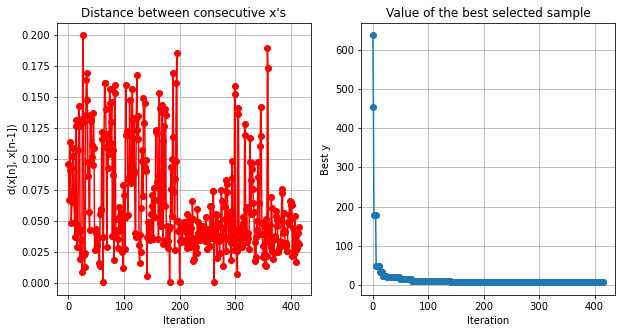

In [16]:
Opt_rs.plot_convergence()

In [17]:
print(Opt_rs.x_opt)

[0.01644702 0.00372938 0.0063861  0.00779526 0.00084149 0.00136298]


In [18]:
truss([Opt_rs.x_opt], True)

2.7505423797388464
3.2016864830207745
4.445732554693235
6.193367359693541
6.212175353535828
6.270846261558179
+-----------+
| Analyzing |
+-----------+

...Analyzing load combination Combo 1
...Adding spring stiffness terms to global stiffness matrix
...Adding member stiffness terms to global stiffness matrix
...Adding quadrilateral stiffness terms to global stiffness matrix
...Adding plate stiffness terms to global stiffness matrix
...Calculating global displacement vector for load combination Combo 1
...Checking for tension/compression-only spring convergence
...Checking for tension/compression-only member convergence
...Tension/compression-only analysis converged after 1 iteration(s)
...Calculating reactions
...Analysis complete

maximum deflection: 0.00029511870376235067 m
weight: 6.270846261558179 kg


6.56596496532053